In [1]:
#General
import pandas as pd
import numpy as np
import json

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;

# Modeling
import xgboost as xgb
import lightgbm as lgb

# Options
pd.set_option('display.max_columns', 100)

In [2]:
def display_df(df, name):
    '''Display df shape and first row '''
    PrintColor(text = f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===> First row:')
    display(df.head(1))

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    '''Prints color outputs using colorama of a text string'''
    print(style + color + text + Style.RESET_ALL); 

In [3]:
# Read CSV
train = pd.read_csv("train.csv")
gas = pd.read_csv("gas_prices.csv")
electricity = pd.read_csv("electricity_prices.csv")
h_weather = pd.read_csv("historical_weather.csv")
f_weather = pd.read_csv("forecast_weather.csv")
client = pd.read_csv("client.csv")

In [4]:
display_df(train, 'train')
display_df(gas, 'gas prices')
display_df(electricity, 'electricity prices')
display_df(h_weather, 'historic weather')
display_df(f_weather, 'forecast weather')
display_df(client, 'client')

train data has 2018352 rows and 9 columns. 
 ===> First row:


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0


gas prices data has 637 rows and 5 columns. 
 ===> First row:


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1


electricity prices data has 15286 rows and 4 columns. 
 ===> First row:


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1


historic weather data has 1710800 rows and 18 columns. 
 ===> First row:


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1


forecast weather data has 3424512 rows and 18 columns. 
 ===> First row:


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0


client data has 41919 rows and 7 columns. 
 ===> First row:


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2


## Data processing

In [5]:
class FeatureCollectorClass():
    '''Class to create a feature collector dataframe df for both train and test set'''
    
    def __init__(self, is_train=True):
                
        # Boolean for train set or test set
        self.is_train = is_train
        
        # Columns no change (no renaiming)
        self.columns_no_change = ['datetime', 'data_block_id'] 
        
        # Columns to take from the datasets
        self.revealed_targets_columns = ['prediction_unit_id', 'is_consumption', 'target', 'datetime']
        self.gas_columns = ['lowest_price_per_mwh', 'highest_price_per_mwh', 'data_block_id']
        self.electricity_columns = ['euros_per_mwh', 'datetime', 'data_block_id']
        self.client_columns = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'data_block_id']
        
        # Categorical columns (for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']
            
    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Changes column names, by given suffix, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 
    
    def create_df_features(self, data, revealed_targets, client, h_weather, f_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''

        # ---- Process data ------ #
        if self.is_train:
            data = data[data['target'].notnull()].reset_index(drop=True) # drop rows with empty target
        else:
            data = data.rename(columns = {'prediction_datetime': 'datetime'}) # rename test 
        
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Date, year, month, week
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        
        # Day of year,  Day of month, Day of week
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        
        # Hour
        data['hour'] = data['datetime'].dt.hour
        
        # ---- Process revealed targets ------ #
        if self.is_train:
            revealed_targets = data[self.revealed_targets_columns].copy()
        else:
            revealed_targets = revealed_targets[self.revealed_targets_columns].copy()
        revealed_targets['datetime'] = revealed_targets['datetime'] + pd.DateOffset(2)
        revealed_targets = self.create_new_column_names(df = revealed_targets, 
                                                        suffix = '_revealed', 
                                                        columns_no_change = ['prediction_unit_id', 'is_consumption', 'datetime'])
        
        # ---- Process electricity prices ------ #
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # ---- Process historical weather ------ #
        h_weather['datetime'] = pd.to_datetime(h_weather['datetime'])
        h_weather_mean = h_weather.groupby(['datetime', 'data_block_id']).mean().reset_index()
        h_weather_mean['hour'] = h_weather_mean['datetime'].dt.hour
        h_weather_mean['datetime'] = ( h_weather_mean.apply(lambda x: x['datetime'] + pd.DateOffset(1) 
                                                           if x['hour']< 11 
                                                           else x['datetime'] + pd.DateOffset(2),
                                                           axis=1)
                                     )  
        h_weather_mean = self.create_new_column_names(h_weather_mean, 
                                                      suffix='_h',
                                                      columns_no_change = self.columns_no_change
                                                     )
        # ---- Process forecast weather ------ #
        f_weather['forecast_datetime'] = pd.to_datetime(f_weather['forecast_datetime']).dt.tz_localize(None)
        f_weather['origin_datetime'] = pd.to_datetime(f_weather['origin_datetime']).dt.tz_localize(None)
        f_weather_mean = f_weather.groupby(['origin_datetime', 'hours_ahead', 'data_block_id']).mean().reset_index()
        f_weather_mean = f_weather_mean.rename(columns = {'forecast_datetime': 'datetime'})   
        f_weather_mean = self.create_new_column_names(f_weather_mean, 
                                                      suffix='_f',
                                                      columns_no_change = self.columns_no_change
                                                     )
        
        # ---- Merge all datasets into one df ------ #
        df = data.merge(revealed_targets, how = 'left', on = ['prediction_unit_id', 'is_consumption', 'datetime'], suffixes = ('', '_past'))
        df = df.merge(gas[self.gas_columns], how='left', on = 'data_block_id')
        df = df.merge(electricity[self.electricity_columns], how='left', on = self.columns_no_change)
        df = df.merge(client[self.client_columns], how='left', on =['product_type', 'county', 'is_business', 'data_block_id'])
        df = df.merge(h_weather_mean, how='left', on = self.columns_no_change)
        df = df.merge(f_weather_mean, how='left', on = self.columns_no_change)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        
        return df                    

In [6]:
%%time
FeatureCollectorTrain = FeatureCollectorClass(is_train=True)

df = FeatureCollectorTrain.create_df_features(data = train,
                                              revealed_targets = None,
                                              client = client,
                                              h_weather = h_weather,
                                              f_weather = f_weather,
                                              electricity = electricity,
                                              gas = gas
                                        )

CPU times: total: 7.94 s
Wall time: 13.5 s


## XGBoost single fold

In [7]:
# Create single fold
train_block_id = list(range(0, 600)) 

train = df[df['data_block_id'].isin(train_block_id)] # first 600 data_block_ids used for training
val = df[~df['data_block_id'].isin(train_block_id)] # rest data_block_ids used for validation

In [8]:
df.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'date',
       'year', 'month', 'week', 'day_of_year', 'day_of_month', 'day_of_week',
       'hour', 'target_revealed', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'euros_per_mwh', 'eic_count',
       'installed_capacity', 'temperature_h', 'dewpoint_h', 'rain_h',
       'snowfall_h', 'surface_pressure_h', 'cloudcover_total_h',
       'cloudcover_low_h', 'cloudcover_mid_h', 'cloudcover_high_h',
       'windspeed_10m_h', 'winddirection_10m_h', 'shortwave_radiation_h',
       'direct_solar_radiation_h', 'diffuse_radiation_h', 'latitude_h',
       'longitude_h', 'hour_h', 'origin_datetime_f', 'hours_ahead_f',
       'latitude_f', 'longitude_f', 'temperature_f', 'dewpoint_f',
       'cloudcover_high_f', 'cloudcover_low_f', 'cloudcover_mid_f',
       'cloudcover_total_f', '10_metre_u_wind_component_f',
       '10_metre_v_wind_component_f'

In [9]:
remove_columns = ['target', 'datetime', 'data_block_id', 'row_id', 'date', 'origin_datetime_f']

features = [f for f in df.columns if f not in remove_columns]
target = ['target']

In [10]:
clf = xgb.XGBRegressor(
                        enable_categorical=True,
                        objective = 'reg:absoluteerror',
                        n_estimators = 1500,
                        early_stopping_rounds=100
                       )

In [11]:
clf.fit(X = train[features], 
        y = train[target], 
        eval_set = [(train[features], train[target]), (val[features], val[target])], 
        verbose=True
       )

[0]	validation_0-mae:238.00774	validation_1-mae:307.44633
[1]	validation_0-mae:207.36068	validation_1-mae:275.00053
[2]	validation_0-mae:182.24504	validation_1-mae:243.56135
[3]	validation_0-mae:158.23873	validation_1-mae:206.65124
[4]	validation_0-mae:142.65079	validation_1-mae:184.60196
[5]	validation_0-mae:131.51880	validation_1-mae:172.71592
[6]	validation_0-mae:113.15121	validation_1-mae:154.91261
[7]	validation_0-mae:98.16653	validation_1-mae:140.38148
[8]	validation_0-mae:88.78952	validation_1-mae:132.72177
[9]	validation_0-mae:81.65600	validation_1-mae:126.85693
[10]	validation_0-mae:76.81675	validation_1-mae:123.10883
[11]	validation_0-mae:73.13102	validation_1-mae:119.44607
[12]	validation_0-mae:70.93588	validation_1-mae:118.43164
[13]	validation_0-mae:69.63773	validation_1-mae:117.72317
[14]	validation_0-mae:68.20414	validation_1-mae:117.31552
[15]	validation_0-mae:67.69427	validation_1-mae:117.04318
[16]	validation_0-mae:67.36855	validation_1-mae:116.95006
[17]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

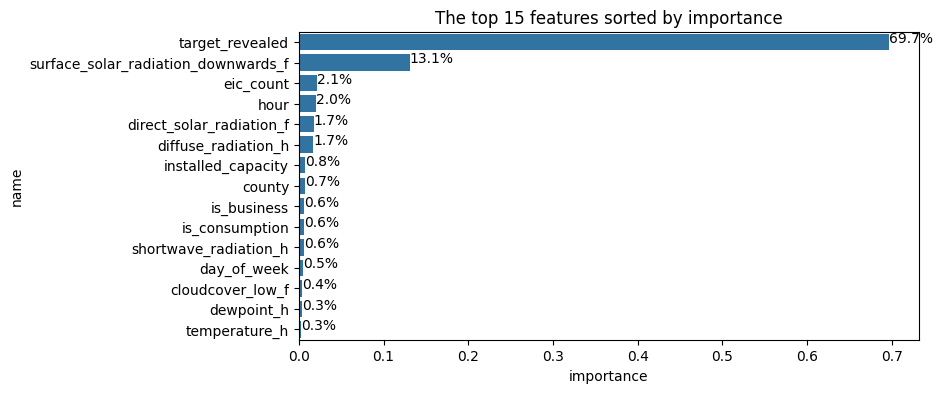

In [12]:
TOP = 15
importance_data = pd.DataFrame({'name': clf.feature_names_in_, 'importance': clf.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 100*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

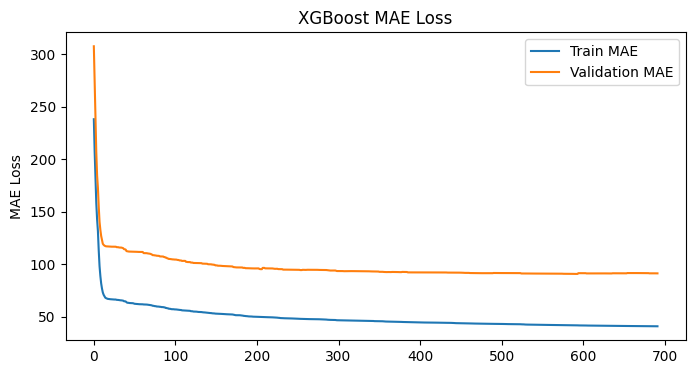

In [13]:
# Plot RMSE
results = clf.evals_result()
train_mae, val_mae = results["validation_0"]["mae"], results["validation_1"]["mae"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train MAE")
ax.plot(x_values, val_mae, label="Validation MAE")
ax.legend()
plt.ylabel("MAE Loss")
plt.title("XGBoost MAE Loss")
plt.show()

### Submit

In [ ]:
# import enefit
# env = enefit.make_env()
# iter_test = env.iter_test()

In [14]:
# FeatureCollectorTest = FeatureCollectorClass(is_train=False)

In [ ]:
# for (test, 
#      revealed_targets, 
#      client_test, 
#      h_weather_test,
#      f_weather_test, 
#      electricity_test, 
#      gas_test, 
#      sample_prediction) in iter_test:
    
#     # Initiate data_block_id to join on (TODO: consider not join on data_block_id)
#     id_column = 'data_block_id' 
    
#     test[id_column] = 0
#     gas_test[id_column] = 0
#     electricity_test[id_column] = 0
#     h_weather_test[id_column] = 0
#     f_weather_test[id_column] = 0
#     client_test[id_column] = 0
#     revealed_targets[id_column] = 0
    
#     df_test = FeatureCollectorTest.create_df_features(test,
#                                                       revealed_targets, 
#                                                       client_test, 
#                                                       h_weather_test,
#                                                       f_weather_test, 
#                                                       electricity_test, 
#                                                       gas_test, 
#                                                 )
    
#     X_test = df_test[features]
#     sample_prediction['target'] = clf.predict(X_test)
#     env.predict(sample_prediction)